<a href="https://colab.research.google.com/github/oduolaidrisA/Scientific-Machine-Learning/blob/main/Evolutional_Deep_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

In this notebook we are going to explore the Evolutional Deep Neural Network (EDNN) proposed by Yifan Du and Tamer Zaki (https://doi.org/10.1103/PhysRevE.104.045303), which is a framework for solving time-dependent PDEs. The approach is to approximate the initial condition using a neural network, then treating the parameters of the neural network as a function of time. Thus, evolving the neural network parameters over time adjusts the neural networks outputs as a solution at that time.

In this notebook, we will be solving the 1D inviscid Burgers equation using EDNN.

In [1]:
import os

#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import linalg as LA
import torch.nn as nn
from torch.autograd import grad
from pathlib import Path
import torch.optim as optim
from torch.nn.utils import parameters_to_vector, vector_to_parameters #Converts parameters to a vector and vice-versa
from torch.func import functional_call #Allows temporary swapping of new parameters/buffers in a module
from collections import OrderedDict   #To preserve ordering of dictionary keys
from torch.autograd.functional import jacobian #To compute jacobians

torch.manual_seed(1234)

np.random.seed(1234)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

cuda
Tesla T4


In [2]:
#Defining the hyperparameters
class config:
    def __init__(self):
        self.x_grid = torch.linspace(-1,1,1000).view(-1,1).float()
        self.u0 = lambda x: -torch.sin(torch.pi * x)
        #No of neurons in each hidden layer
        self.hl_dim = 20
        self.dt = 1e-3
        self.epochs = 10000
        self.lr = 5e-4 #Subject to tuning
        self.layers = 4

cfg = config()

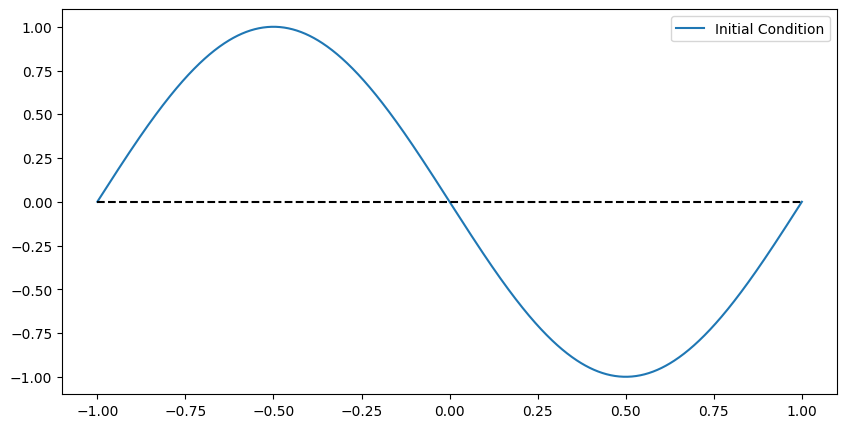

In [3]:
u0 = cfg.u0(cfg.x_grid)
#Plotting the initial condition
plt.figure(figsize = (10,5))
plt.plot(cfg.x_grid,u0,label = 'Initial Condition')
plt.plot(cfg.x_grid, torch.zeros_like(cfg.x_grid), 'k--')
plt.legend()
plt.show()

### The NN Module

In [4]:
class NN(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.activation = nn.Tanh()
        self.hidden_dim = cfg.hl_dim
        self.input_dim = 1
        self.layers = cfg.layers #The number of layers

        #Defining the linear layers
        self.linears = nn.ModuleList()

        self.linears.append(nn.Linear(self.input_dim, self.hidden_dim)) #The first layer
        #Other layers
        for _ in range(self.layers - 2):
            self.linears.append(nn.Linear(self.hidden_dim, self.hidden_dim))

        self.linears.append(nn.Linear(self.hidden_dim, 1)) #Output

    def forward(self,x):
        a = x.float()
        for linear in self.linears[:-1]:
            a = self.activation(linear(a))
        return self.linears[-1](a)

#### Learning Rate Finder

In [5]:
#We want to find the best lr for our defined model
model_lr = NN(cfg).to(device)
optimizer_lr = optim.Adam(model_lr.parameters(), lr=1e-7)

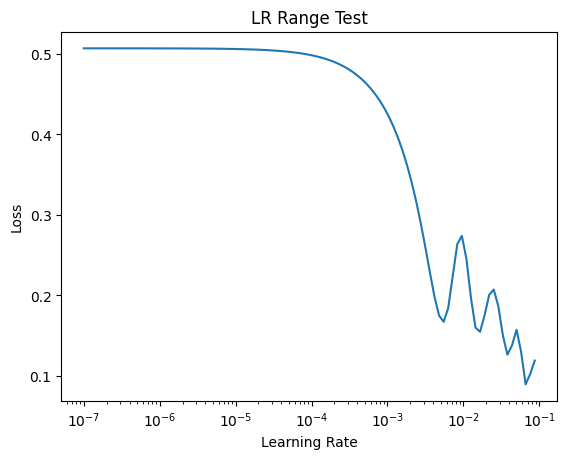

In [6]:
losses = []
lrs = []

start_lr = 1e-7
end_lr = 1e-1
num_iter = 100
lr_mult = (end_lr / start_lr) ** (1/num_iter)

lr = start_lr
x_grid = cfg.x_grid.to(device)
u0 = cfg.u0(x_grid)

for i in range(num_iter):
    optimizer_lr.param_groups[0]['lr'] = lr

    optimizer_lr.zero_grad()
    u0_hat = model_lr(x_grid)
    loss = torch.mean((u0_hat - u0)**2)
    loss.backward()
    optimizer_lr.step()

    lrs.append(lr)
    losses.append(loss.item())

    lr *= lr_mult  # increase learning rate exponentially

# Plot the result
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('LR Range Test')
plt.show()

### Training

In [7]:
ednn = NN(cfg)
ednn.to(device)
print(ednn)
optimizer = optim.Adam(ednn.parameters(), lr=5e-4)

NN(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1-2): 2 x Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [8]:
metric = {'loss':[]}
for iter in range(cfg.epochs +1):
  optimizer.zero_grad()

  u0_hat = ednn(x_grid)
  assert u0_hat.shape == u0.shape, f"Shape Mismatch! prediction shape:{u0_hat.shape}, target shape: {u0.shape}"
  loss = torch.mean((u0_hat - u0)**2)
  metric["loss"].append(loss.item())

  if iter %(cfg.epochs//10) == 0:
    print(f"Epoch: {iter} ---- loss: {loss.item()}")

  loss.backward()
  optimizer.step()

Epoch: 0 ---- loss: 0.4855528771877289
Epoch: 1000 ---- loss: 0.00023076834622770548
Epoch: 2000 ---- loss: 9.176487765216734e-06
Epoch: 3000 ---- loss: 3.89902243114193e-06
Epoch: 4000 ---- loss: 5.776919806521619e-06
Epoch: 5000 ---- loss: 2.354025127715431e-06
Epoch: 6000 ---- loss: 1.9009756897503394e-06
Epoch: 7000 ---- loss: 1.4727113466506125e-06
Epoch: 8000 ---- loss: 1.8741801568467054e-06
Epoch: 9000 ---- loss: 8.974282650342502e-07
Epoch: 10000 ---- loss: 6.22670143002324e-07


### Evaluation

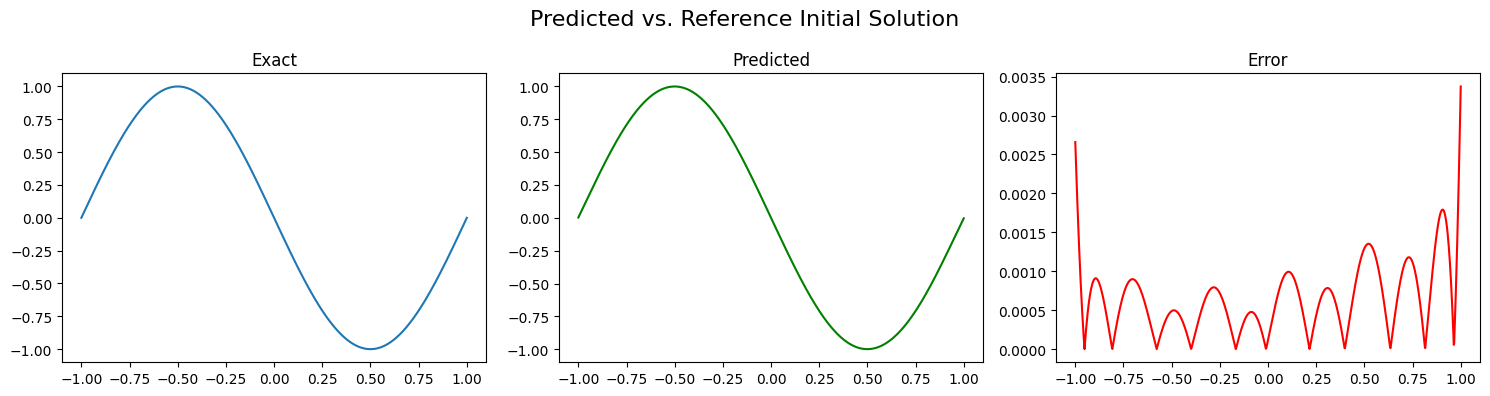

In [9]:
ednn.eval()

u0_test = ednn(cfg.x_grid.to(device)).detach().cpu()
u0 = u0.cpu()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Predicted vs. Reference Initial Solution", fontsize=16)
# Plot each function in its own subplot
ax1.plot(cfg.x_grid, u0)
ax1.set_title("Exact")

ax2.plot(cfg.x_grid, u0_test, color = "green")
ax2.set_title("Predicted")

diff = torch.abs(u0_test - u0)
ax3.plot(cfg.x_grid, diff, color = 'red')
ax3.set_title("Error")

plt.tight_layout()
plt.show()

In [10]:
checkpoint = {
    'model_state_dict': ednn.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}
torch.save(checkpoint, f'initial_model.pth')

### Computing Time Derivatives

Given that the Burgers equation is defined as:
\begin{equation} \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0, \end{equation}

We have that $$\mathcal{N}(u) = - u \frac{\partial u}{\partial x}, $$
from which we can compute the optimal weight derivative with respect to time.

In light of that, we are going to need to compute:
* Functions evaluating the operator $\mathcal{N}(u)$.
* The Jacobian $J$.
* $\gamma^{opt}$.
* Forward Euler (or Runge-Kutta): \begin{equation} W^{n+1} = W^{n} + \gamma^{opt} \Delta t. \end{equation}
* Finally, an update for $u(x,t)$: \begin{equation} u(x,t^{n+1}) = \hat{u}_k(W^{n+1}). \end{equation}

### Linear-Advection equation, with $c = 1$

In [136]:
#Before solving for the Burgers equation, we can solve for the linear-advection equation, with c = 1, so N(u) = -∂u/∂x
class EDNNSolver:
  def __init__(self, model, cfg):
    self.model = model
    self.cfg = cfg
    self.W = parameters_to_vector(self.model.parameters()).detach().to(device).requires_grad_(True)

    #We need these to update parameters with their names, else the Jacobian matrix will be zeros
    self.params = dict(model.named_parameters()) #Model parameters
    self.param_shapes = [p.shape for p in self.params.values()] #Shape of all branch parameters
    self.param_names = list(self.params.keys()) #Names of all branch parameter

    self.W = parameters_to_vector(self.params.values()).detach().clone().requires_grad_(True) #Extracting the model parameters


  #Replace parameters with updated parameters. This is essential for computing the Jacobian
  def vector_to_named_parameters(self,w, p_names, p_shapes):
    sizes = [torch.tensor(s).prod().item() for s in p_shapes] #Total number of elements in each parameter (weight or bias)
    splits = torch.split(w, sizes) #Splits the flat vector of parameters into chunks according to the number of elements in each parameters
    #Reshapes each chunk into the model parameters and returns an ordered dictionary
    return OrderedDict(
        (name, param.view(shape))
        for name, shape, param in zip(p_names, p_shapes, splits)
    )

  def set_params(self, W): #Updates the parameters of the model
    vector_to_parameters(W, self.model.parameters())

  def compute_u(self, x):
    return self.model(x)

  def dfx(self, f, x): #Automatic differentiation
    return  grad(f, x, grad_outputs=torch.ones_like(f), create_graph=True)[0]

  #For the linear-advection equation
  def Nu(self, x):
    #u_new = self.compute_u(x)
    return - self.dfx(self.compute_u(x), x).view(-1)

  #Computing the jacobian
  def Jacobian(self, x):
    def model_out(w):
      named_param_dict = solver.vector_to_named_parameters(w, self.param_names, self.param_shapes)
      out = functional_call(self.model, named_param_dict, (x,))
      return out.view(-1)

    return jacobian(model_out, self.W)

  #The Linear system solver
  def lin_sys_solver(self, j, n):
    A = j.T @ j
    b = j.T @ n
    A_inv = torch.linalg.pinv(A)
    gamma = A_inv @ b
    return gamma

  #Updating the model parameters using forward Euler
  def update_params_euler(self, gamma, dt):
    self.W = self.W + dt *gamma
    self.set_params(self.W)

  def test_update_params(self,w,gamma,dt):
    self.W = w + dt *gamma
    self.set_params(self.W)

  #Finally, putting all together
  def evolution_update(self,total_time,dt,x):
    Nt = int(total_time / dt); u = []
    for i in range(Nt):
      J = self.Jacobian(x)
      nu = self.Nu(x)
      gamma = self.lin_sys_solver(J, nu)
      self.update_params_euler(gamma, dt)
      if i % (Nt//10) == 0:
        print(f"Updated for time {dt*(i+1):.2f}")
      u_pred = self.compute_u(x).detach().cpu()
      u.append(u_pred)
    return torch.cat(u, dim = 1)

  #testing evolution on first parameter change only
  def test_evolution_update(self,total_time,dt,x):
    Nt = int(total_time / dt); u = []
    J = self.Jacobian(x); nu = self.Nu(x)
    gamma = self.lin_sys_solver(J, nu)
    W = self.W
    dt_new = dt
    for i in range(Nt):
      self.test_update_params(W, gamma, dt_new)
      print(f"Updated for time {dt_new:.2f}")
      print("--------------------------")
      u_pred = self.compute_u(x).detach().cpu()
      u.append(u_pred)
      dt_new+=dt
    return torch.cat(u, dim = 1)


In [137]:
checkpoint = torch.load('initial_model.pth', map_location=torch.device('cuda'))
ednn.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [138]:
solver = EDNNSolver(ednn, cfg)

In [117]:
x_grid = cfg.x_grid.to(device).requires_grad_(True)
u_hat = solver.evolution_update(1, 0.1, x_grid)

Updated for time 0.10
Updated for time 0.20
Updated for time 0.30
Updated for time 0.40
Updated for time 0.50
Updated for time 0.60
Updated for time 0.70
Updated for time 0.80
Updated for time 0.90
Updated for time 1.00


In [118]:
ednn.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [119]:
u_test = solver.test_evolution_update(1,0.1,x_grid)

Updated for time 0.10
--------------------------
Updated for time 0.20
--------------------------
Updated for time 0.30
--------------------------
Updated for time 0.40
--------------------------
Updated for time 0.50
--------------------------
Updated for time 0.60
--------------------------
Updated for time 0.70
--------------------------
Updated for time 0.80
--------------------------
Updated for time 0.90
--------------------------
Updated for time 1.00
--------------------------


In [122]:
def exact(x,t):
  return - torch.sin(torch.pi * (x - t))
tm = torch.arange(0.1,1.1,0.1) #.view(-1,1)

#Exact solution at different times
u_exact = exact(cfg.x_grid, tm)

In [123]:
#We can see that accuracy is reducing over time
for i in range(10):
  err1 = torch.mean((u_exact[:,i] - u_hat[:,i])**2)
  err2 = torch.mean((u_exact[:,i] - u_test[:,i])**2)
  print(f"Error at time {tm[i]:.1f}: Evolution {err1:.6f} -- No evolution {err2:.6f}")


Error at time 0.1: Evolution 0.000005 -- No evolution 0.000005
Error at time 0.2: Evolution 0.000010 -- No evolution 0.000034
Error at time 0.3: Evolution 0.000021 -- No evolution 0.000107
Error at time 0.4: Evolution 0.000104 -- No evolution 0.000564
Error at time 0.5: Evolution 0.000712 -- No evolution 0.002895
Error at time 0.6: Evolution 0.003497 -- No evolution 0.011126
Error at time 0.7: Evolution 0.012468 -- No evolution 0.033399
Error at time 0.8: Evolution 0.034959 -- No evolution 0.082895
Error at time 0.9: Evolution 0.081879 -- No evolution 0.177267
Error at time 1.0: Evolution 0.166125 -- No evolution 0.336143


###### From the above result, it shows that computing the gradient at every step is unnecessary if the time step is uniform and very small. Another way to see this is to consider using adaptive stepping.

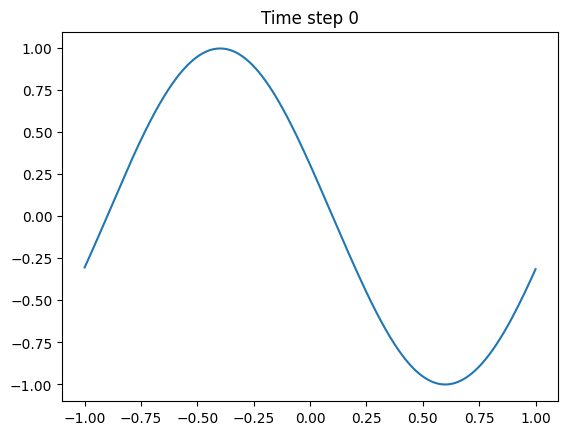

In [127]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
line, = ax.plot(cfg.x_grid, u_test[:, 0])

def update(i):
    line.set_ydata(u_test[:, i])
    ax.set_title(f"Time step {i}")
    return line,

ani = FuncAnimation(fig, update, frames=u_hat.shape[1], interval=200)
#HTML(ani.to_jshtml())  # or ani.to_html5_video()
ani.save('evolution_solution_at_only_one_dt.gif', writer='imagemagick')  # or 'solution.gif', writer='imagemagick'

##### Extracting only some parameters

In [127]:
#Reinitializing the model
ednn.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [128]:
all_named_params = list(ednn.named_parameters())
last_two_named_params = all_named_params[-4:]  # 2 weights + 2 biases
param_names = [name for name, _ in last_two_named_params]
param_tensors = [p for _, p in last_two_named_params]
param_shapes = [p.shape for p in param_tensors]

# Flatten into a single vector
W = parameters_to_vector(param_tensors).detach().to(device).requires_grad_(True)
W.shape

torch.Size([441])

In [129]:
# Start from all current parameters
full_named_params = dict(ednn.named_parameters())
full_named_params = OrderedDict(full_named_params)

# Replace the last two layers' weights
partial_named_params = solver.vector_to_named_parameters(W, param_names, param_shapes)
for name, param in partial_named_params.items():
    full_named_params[name] = param  # replace only selected layers

In [130]:
def model_out(w):
    # Update only last two layers in full param dict
    full_named_params = dict(ednn.named_parameters())
    full_named_params = OrderedDict(full_named_params)

    partial_named_params = solver.vector_to_named_parameters(w, param_names, param_shapes)
    for name, param in partial_named_params.items():
        full_named_params[name] = param

    out = functional_call(ednn, full_named_params, (x_grid,))
    return out.view(-1)

In [131]:
J = jacobian(model_out, W)
J.shape

torch.Size([1000, 441])

In [132]:
A = J.T @ J
print(A.shape)
nu = solver.Nu(x_grid.requires_grad_(True))
b = J.T @ nu
print(b.shape)

torch.Size([441, 441])
torch.Size([441])


In [133]:
rank = torch.linalg.matrix_rank(A)
print(f"Matrix rank: {rank}, expected: {A.shape[0]}")

Matrix rank: 8, expected: 441


In [134]:
A_inv = torch.linalg.pinv(A)
gamma = A_inv @ b
gamma.shape

torch.Size([441])

In [135]:
W_new = W + gamma * dt

W_new.shape

torch.Size([441])

In [136]:
def set_partial_params(model, named_param_dict):
    for name, param in model.named_parameters():
        if name in named_param_dict:
            param.data.copy_(named_param_dict[name].data)


In [137]:
named_param_dict = solver.vector_to_named_parameters(W_new, param_names, param_shapes)
set_partial_params(ednn, named_param_dict)

In [138]:
u1_exact = exact(cfg.x_grid, dt)
u1_pred_new = solver.compute_u(cfg.x_grid.to(device)).detach().cpu()

In [139]:
torch.mean((u1_exact - u1_pred_new)**2)

tensor(0.0008)

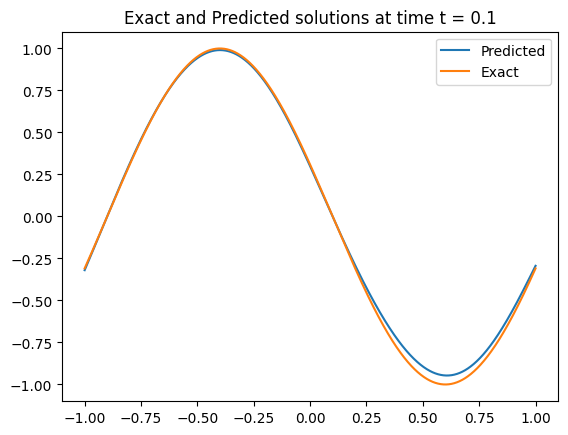

In [140]:
#Visualizing
plt.title(f"Exact and Predicted solutions at time t = {dt}")
plt.plot(cfg.x_grid.squeeze(1), u1_pred_new.view(-1), label = f"Predicted")
plt.plot(cfg.x_grid.squeeze(1), u1_exact.view(-1), label = f"Exact")
plt.legend()
plt.show()

### Burgers Equation

In [159]:
def Nu_burgers(x):
    u_new = solver.compute_u(x)
    u_x = solver.dfx(u_new, x)
    return (- u_new * u_x + 0.01 * solver.dfx(u_x,x)).view(-1) #viscocity coefficient is 0.01

def evolution_update(total_time,dt,x):
    Nt = int(total_time / dt); u = []
    for i in range(Nt):
      J = solver.Jacobian(x)
      nu = Nu_burgers(x)
      gamma = solver.lin_sys_solver(J, nu)
      solver.update_params_euler(gamma, dt)
      if i % (Nt//10) == 0:
        print(f"Updated for time {dt*(i+1):.2f}")
      u_pred = solver.compute_u(x).detach().cpu()
      u.append(u_pred)
    return torch.cat(u, dim = 1)

In [160]:
x_grid = cfg.x_grid.to(device).requires_grad_(True)
nu = Nu_burgers(x_grid)
print(nu.shape)

torch.Size([1000])


In [161]:
ednn.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [162]:
dt = 5e-2
u_hat_burgers = evolution_update(1, dt, x_grid)

Updated for time 0.05
Updated for time 0.15
Updated for time 0.25
Updated for time 0.35
Updated for time 0.45
Updated for time 0.55
Updated for time 0.65
Updated for time 0.75
Updated for time 0.85
Updated for time 0.95


In [163]:
u_hat_burgers.shape

torch.Size([1000, 20])

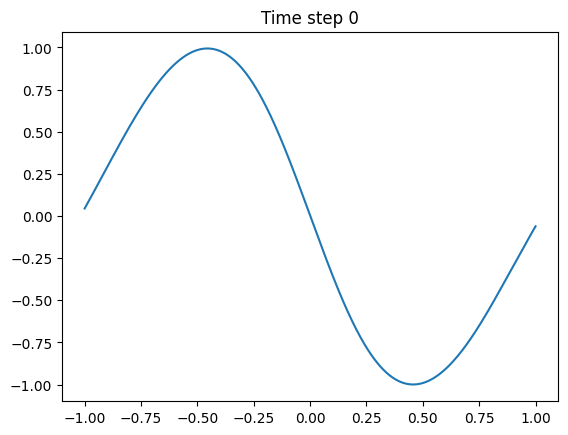

In [164]:
fig, ax = plt.subplots()
line, = ax.plot(cfg.x_grid, u_hat_burgers[:, 0])

def update(i):
    line.set_ydata(u_hat_burgers[:, i])
    ax.set_title(f"Time step {i}")
    return line,

ani = FuncAnimation(fig, update, frames=u_hat_burgers.shape[1], interval=200)
#HTML(ani.to_jshtml())  # or ani.to_html5_video()
ani.save('viscous_burgers_evolution.gif', writer='imagemagick')  # or 'solution.gif', writer='imagemagick'